In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive
from torchvision.datasets.utils import download_url

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# zip_path = base/’size_test/cats_dogs.zip’
# !cp “{zip_path}” .

# source_path = '/content/drive/MyDrive/Colab Notebooks/Sample_data/processed_celeba_small'

# !cp -r "{source_path}" .

^C


In [ ]:
dataset_url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip"
download_url(dataset_url, '.')

  0%|          | 0/247694507 [00:00<?, ?it/s]

In [ ]:
!unzip "/content/processed-celeba-small.zip" -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: ./processed_celeba_small/celeba/New Folder With Items/05

In [ ]:
# dataroot='/content/drive/MyDrive/Colab Notebooks/Sample_data/processed_celeba_small'

dataroot='/content/processed_celeba_small'

dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(32),
        # transforms.Resize(64),
        transforms.CenterCrop(32),
        # transforms.CenterCrop(64),
        transforms.ToTensor()
        ])
        )

dataloader=DataLoader(dataset,num_workers=0,batch_size=128,shuffle=True)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 89931
    Root location: /content/processed_celeba_small
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(32, 32))
               ToTensor()
           )

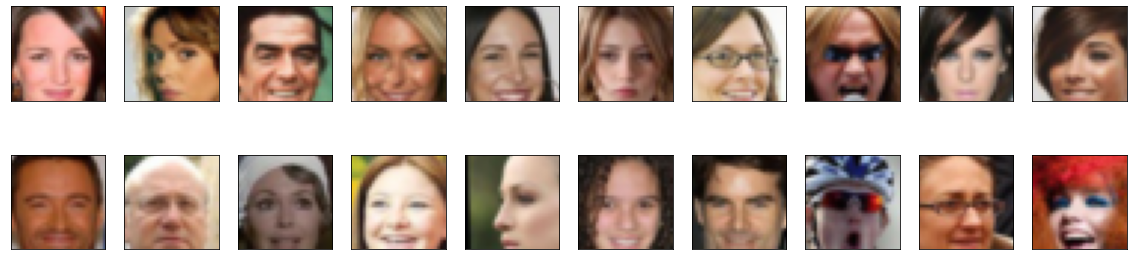

In [ ]:
dataiter=iter(dataloader)
images,labels=dataiter.next()

def RGBshow(img):
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    
plot_only=20
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
    ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])

In [ ]:
def scale(img):
    img=img*2-1
    return img

scaled_img=scale(images[0])
scaled_img.min(),scaled_img.max()

(tensor(-0.9529), tensor(0.9529))

In [ ]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*4,4,batch_norm=False)
        self.conv4=conv(conv_dim*4,conv_dim*8,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*8*2*2,1)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*8*2*2)
        out=self.fc(x)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)

        self.deconv1 = deconv(conv_dim*8,conv_dim*4,4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv3 = deconv(conv_dim*2,conv_dim,4)
        self.deconv4 = deconv(conv_dim,3,4,batch_norm=False)

    def forward(self,x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        out = F.tanh(x)
        return out

In [ ]:
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

z_size=100
D=Discriminator(32)
G=Generator(z_size,32)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
def real_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size) * 0.9

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size)

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss    
  

    
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

In [ ]:
samples = []
losses = []

In [ ]:
import pickle as pkl

def train(D, G, n_epochs, print_every=300):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if use_cuda and torch.cuda.is_available():
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()


            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses
  



n_epochs = 50

# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Streaming output truncated to the last 5000 lines.
Epoch [   43/   50] | d_loss: 0.3886 | g_loss: 0.3600
Epoch [   43/   50] | d_loss: 0.3896 | g_loss: 0.3577
Epoch [   43/   50] | d_loss: 0.3888 | g_loss: 0.3538
Epoch [   43/   50] | d_loss: 0.3903 | g_loss: 0.3657
Epoch [   43/   50] | d_loss: 0.3898 | g_loss: 0.3541
Epoch [   43/   50] | d_loss: 0.3890 | g_loss: 0.3656
Epoch [   43/   50] | d_loss: 0.3879 | g_loss: 0.3592
Epoch [   43/   50] | d_loss: 0.3910 | g_loss: 0.3627
Epoch [   43/   50] | d_loss: 0.3922 | g_loss: 0.3541
Epoch [   43/   50] | d_loss: 0.3996 | g_loss: 0.3803
Epoch [   43/   50] | d_loss: 0.3997 | g_loss: 0.3600
Epoch [   43/   50] | d_loss: 0.3899 | g_loss: 0.3536
Epoch [   43/   50] | d_loss: 0.3902 | g_loss: 0.3758
Epoch [   43/   50] | d_loss: 0.3942 | g_loss: 0.3596
Epoch [   43/   50] | d_loss: 0.3908 | g_loss: 0.3536
Epoch [   43/   50] | d_loss: 0.3889 | g_loss: 0.3601
Epoch [   43/   50] | d_loss: 0.3897 | g_loss: 0.3572
Epoch [   43/   50] | d_loss: 0

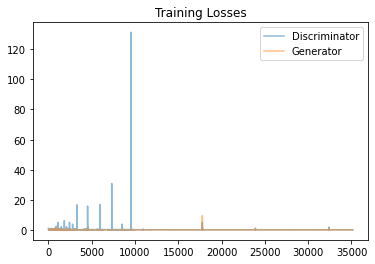

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

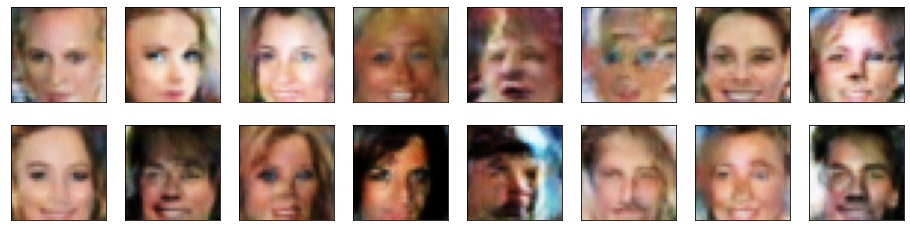

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
        

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
G.state_dict()

OrderedDict([('fc.weight',
              tensor([[-0.0736, -0.0047, -0.0623,  ..., -0.0365, -0.1077,  0.0020],
                      [ 0.0382, -0.0324,  0.0338,  ..., -0.0228, -0.0272,  0.0085],
                      [-0.1785, -0.0103, -0.1417,  ..., -0.0561, -0.1883,  0.1639],
                      ...,
                      [-0.0225,  0.0303, -0.0352,  ..., -0.0137, -0.0229,  0.0542],
                      [ 0.0124, -0.0281,  0.0208,  ...,  0.0071,  0.0666, -0.0982],
                      [ 0.0312, -0.0421,  0.0402,  ..., -0.0045,  0.0338,  0.0060]],
                     device='cuda:0')),
             ('fc.bias',
              tensor([-0.0151,  0.0128,  0.0362,  ...,  0.0939, -0.0252,  0.0902],
                     device='cuda:0')),
             ('deconv1.0.weight',
              tensor([[[[-4.4778e-02, -8.2303e-02,  7.5094e-02, -6.7329e-02],
                        [-1.5628e-02, -1.8109e-02, -6.0852e-02,  7.5730e-02],
                        [-6.3800e-02, -7.2418e-03, -5.2862e-02,

In [ ]:
source_path = '/content/drive/MyDrive/Colab Notebooks/Sample_data'

!cp -r /content/train_samples.pkl "{source_path}"

In [ ]:
!cp -r /content/D.ckpt "{source_path}"
!cp -r /content/G.ckpt "{source_path}"

In [ ]:
checkpoint = torch.load(PATH)
D2.load_state_dict(checkpoint['D.ckpt'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
path_to_checkpoint = '/content/drive/MyDrive/Colab Notebooks/Sample_data'

import os

def save_checkpoint(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'gen': G.state_dict(), 'disc': D.state_dict(), 'optim_d': d_optimizer.state_dict(), 'optim_g':g_optimizer.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth'))

def load_checkpoint(G1, D1, d_optimizer1, g_optimizer1):
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth'))
  G1.load_state_dict(dic['gen'])
  D1.load_state_dict(dic['disc'])
  d_optimizer1.load_state_dict(dic['optim_d'])
  g_optimizer1.load_state_dict(dic['optim_g'])
  return dic['e']

In [ ]:
e=50
save_checkpoint(e)

In [ ]:
D2=Discriminator(32)
G2=Generator(z_size,32)
d_optimizer2 = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer2 = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

path_to_checkpoint = '/content/drive/MyDrive/Colab Notebooks/Sample_data'
load_checkpoint(G2, D2, d_optimizer2, g_optimizer2)

50